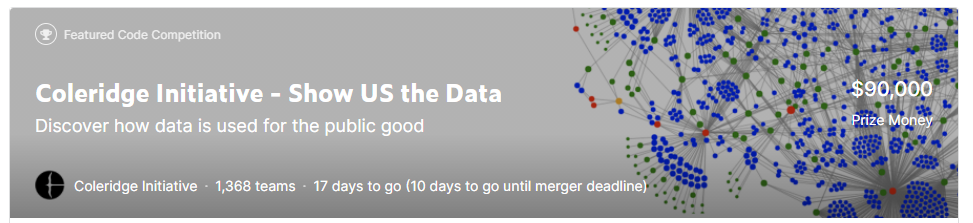

# About

このコンペティションは、データ サイエンティストに、公的資金によるデータが科学と社会にどのように使用されているかを示すことを求めています。政府が社会が直面している多くの脅威に対処するためには、データによる証拠が重要です。パンデミック、気候変動、アルツハイマー病、子供の飢餓、食糧生産の増加、生物多様性の維持、その他多くの課題への取り組み。しかし、証拠や科学に情報を提供するために必要なデータに関する情報の多くは、出版物の中に閉じ込められています。

自然言語処理は、目に見えないデータの引用を見つけることができますか?機械学習は、研究記事で使用されている単語と記事で参照されているデータとの間のリンクを見つけることができますか?

今こそ、データ サイエンティストがデータと証拠への信頼を回復する手助けをするときです。米国では、連邦機関は現在、データがどのように使用されているかを示すことが義務付けられています。新しい根拠に基づく政策立案法では、政府機関はデータ管理を最新化する必要があります。新しい大統領令により、政府機関は、入手可能な最良のデータと科学に基づいて証拠に基づいた決定を行うよう求められています。そして政府は、オープンで透明な方法で対応するために取り組んでいます。

このコンテストは、まさにそのようなオープンで透明なアプローチを構築します。結果は、公的データが科学でどのように使用されているかを示し、政府がより賢明で透明性の高い公共投資を行うのに役立ちます。これにより、研究者や政府は、アドホックな方法を使用することから、問題を解決するために使用されているデータセット、生成されている対策、およびどの研究者が専門家であるかを見つける自動化された方法に移行するのに役立ちます。過去のコンテストでは、データへの参照の検索と発見を自動化するアルゴリズムを開発できることが示されています。現在、私たちは Kaggle コミュニティが科学出版物で使用される重要なデータセットを特定するための最良のアプローチを開発することを望んでいます。

このコンテストでは、自然言語処理 (NLP) を使用して、科学データが出版物でどのように参照されているかの発見を自動化します。 CHORUS の出版社のメンバーやその他の情報源から集められた数多くの研究分野からの科学出版物の全文を利用して、出版物の著者が研究で使用したデータ セットを特定します。

成功した場合は、政府データの証拠をサポートするのに役立ちます。自動化された NLP アプローチにより、政府機関や研究者は必要な情報をすばやく見つけることができます。このアプローチは、データ使用スコアカードを開発するために使用され、政府機関がデータがどのように使用されているかをよりよく示し、公開データへのアクセスと使用に対する重大な障壁を取り除くために使用されます。

コールリッジ イニシアチブは、社会的利益のためにデータを使用するために設立された非営利団体です。組織がこれを行う 1 つの方法は、公的に利用可能な研究を通じて科学を推進することです。


コンテストの目的は、科学出版物内のデータセットへの言及を特定することです。あなたの予測は、データセットに注目しているように見える出版物からの短い抜粋です。出版物内のデータセットを識別するために使用された正確な単語とより正確に一致する予測は、より高いスコアになります。予測は、適切な一致を確実にするために、評価ページの clean_text 関数を使用してクリーンアップする必要があります。

出版物は JSON 形式で提供され、セクション タイトルの付いたセクションに分割されます。

このコンテストの目標は、既知のデータセット文字列を一致させるだけでなく、***NLP と統計的手法を使用して、これまで見たことのないデータセットに一般化することです***。公開テスト セットの公開のパーセンテージは、トレーニング セットから取得されます。すべてのデータセットがトレーニングで識別されたわけではないため、これらの未確認のデータセットは、公開テスト ラベルの一部として使用されています。これらは、プライベート テスト セットにラベルを付けるという難しいタスクのガイドとして役立つはずです。

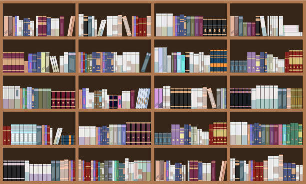

# Setting

In [ ]:
COMPUTE_CV = False
EDA_DEMO = True
ALL_BLENDED = False
BASELINE_HELPING = False
MATCH_ONLY = False
MLM_ONLY = False
KEN_MATCHING = True
BS_CLEANING = False
THEO_MERGE = False
SEED = 42

# Install packages

🎉Bertパッケージをインストール。文章系の問題はすごい難しいんですよね。

In [ ]:
!pip install datasets --no-index --find-links=file:///kaggle/input/coleridge-packages/packages/datasets
!pip install ../input/coleridge-packages/seqeval-1.2.2-py3-none-any.whl
!pip install ../input/coleridge-packages/tokenizers-0.10.1-cp37-cp37m-manylinux1_x86_64.whl
!pip install ../input/coleridge-packages/transformers-4.5.0.dev0-py3-none-any.whl

from IPython.display import clear_output
clear_output()

# Import

In [ ]:
import os
import re
import json
import time
import random
import glob
import importlib

import numpy as np
import pandas as pd

from tqdm.autonotebook import tqdm

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, \
AutoModelForMaskedLM, Trainer, TrainingArguments, pipeline

from typing import List
import string
from functools import partial
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

sample_submission = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
if len(sample_submission) > 4: COMPUTE_CV = False
if COMPUTE_CV: 
    print('this submission notebook will compute CV score but commit notebook will not')
else:
    print('this submission notebook will only be used to submit result')

# Load data

In [ ]:
train_path = '../input/coleridgeinitiative-show-us-the-data/train.csv'
train_files_path = '../input/coleridgeinitiative-show-us-the-data/train'
train = pd.read_csv(train_path)

if COMPUTE_CV: 
    sample_submission = train
    paper_test_folder = '../input/coleridgeinitiative-show-us-the-data/train'
    test_files_path = paper_test_folder
else:
    sample_submission = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
    paper_test_folder = '../input/coleridgeinitiative-show-us-the-data/test'
    test_files_path = paper_test_folder
    
adnl_govt_labels_path = '../input/coleridge-additional-gov-datasets-22000popular/data_set_800_with2000popular.csv'

ファイル
train - トレーニング セットの出版物の JSON 形式の全文、セクション タイトルのあるセクションに分割
test - テスト セットの発行物の全文 (JSON 形式)、セクション タイトル付きのセクションに分割
train.csv - トレーニング セットのラベルとメタデータ
sample_submission.csv - 正しい形式のサンプル提出ファイル

columns
id - パブリケーション ID - 一部のトレーニング ドキュメントには複数の行があり、複数の言及されたデータセットを示していることに注意してください
pub_title - 出版物のタイトル (同じタイトルの出版物が少数あります)
dataset_title - 出版物内で言及されているデータセットのタイトル
dataset_label - データセットを示すテキストの一部
clean_label - 評価ページから clean_text 関数を介して渡されるデータセット ラベル 

In [ ]:
train

In [ ]:
for col in train.columns:
    print(col + ":" + str(len(train[col].unique())))

print("all rows = " + str(len(train)))

# <br>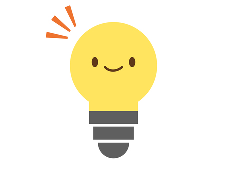

Id　14316個 : 学術論文のidです。trainフォルダには、このid + ".json" ファイルがあります。このjsonファイルが論文の全文章になります。<br>
pub_title 14271個 : 学術論文の出版物のタイトルです。<br>
dataset_title 45個 : パブリケーション内で言及されているデータセットのタイトル。(※　製作者が命名したものらしいです。)<br>
dataset_label 130個 : これを予測します。データセットを示すテキストの一部。（※　論文筆者が使っている名前。省略などあるため、dataset_titleより数が多いらしいです。)<br>
cleaned_label 130個 : evaluation項目にあるように、dataset_labelを小文字とかきれいに整形したものです。submissionはこの形にする必要があります(関数通すだけです)<br>
全部の行は19661個あるのに、たいしてそれぞれ重複しているものがある。


In [ ]:
papers = {}
for paper_id in tqdm(sample_submission['Id']):
    with open(f'{paper_test_folder}/{paper_id}.json', 'r') as f:
        paper = json.load(f)
        papers[paper_id] = paper

🎉テストフォルダーからjsonファイルをpaperとして拾って、papersでつなげている。

In [ ]:
paper[0]

##  🗃EDA
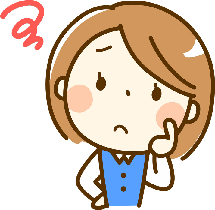

🎉train[id]をキーにして、jsonファイルと統合している。section_titleが''のものがある。

In [ ]:
if EDA_DEMO:
    df_input = pd.DataFrame(columns=['id','section_title','text','data_label'])
    for id in tqdm(train['Id'].values):
        df=pd.read_json('../input/coleridgeinitiative-show-us-the-data/train/{}.json'.format(id))    
        for data_label in train[train['Id']==id]['dataset_label'].values:        
            new_df=df[df['text'].str.contains(data_label)].copy(deep=True)
            new_df.loc[:,['data_label']] = data_label
            new_df.loc[:,['id']] = id
            new_df.reset_index(inplace=True,drop=True)
            df_input=pd.concat([df_input, new_df], ignore_index=True)
            df_input.reset_index(inplace=True,drop=True)
else: df_input = None

df_input

#  ****section_titleが''のものを除く。****

In [ ]:
if EDA_DEMO: df_input = df_input[ df_input['section_title'] != '' ]

df_input

# ナレッジ バンクを作成する

In [ ]:
all_labels = set()

for label_1, label_2, label_3 in train[['dataset_title', 'dataset_label', 'cleaned_label']].itertuples(index=False):
    all_labels.add(str(label_1).lower())
    all_labels.add(str(label_2).lower())
    all_labels.add(str(label_3).lower())
    
print(f'No. different labels: {len(all_labels)}')

# 追加の政府データセット
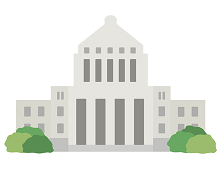

In [ ]:
adnl_govt_labels = pd.read_csv(adnl_govt_labels_path)

for l in adnl_govt_labels.title:
    all_labels.add(l)
    
all_labels = set(all_labels)
print(f'No. different labels: {len(all_labels)}')

In [ ]:
l

### Matching on test data

In [ ]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()


def totally_clean_text(txt):
    txt = clean_text(txt)
    txt = re.sub(' +', ' ', txt)
    return txt

if not BS_CLEANING:
    def text_cleaning(text):
        '''
       すべてのテキストを小文字に変換し、特殊文字、絵文字、複数のスペースを削除します。テキスト - クリーンアップが必要な文
        '''
        text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
        text = re.sub(' +', ' ', text)
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # 顔文字
                                   u"\U0001F300-\U0001F5FF"  # 記号と絵文字
                                   u"\U0001F680-\U0001F6FF"  # 交通及び地図記号
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)
        return text
else:
    def text_cleaning(text):
        '''
        すべてのテキストを小文字に変換し、特殊文字、絵文字、複数のスペースを削除します。テキスト - クリーンアップが必要な文
        '''
        text = ''.join([k for k in text if k not in string.punctuation])
        text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
        # text = re.sub("/'+/g", ' ', text)
        return text


def read_json_pub(filename, train_data_path=train_files_path, output='text'):
    json_path = os.path.join(train_data_path, (filename+'.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
    
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data

In [ ]:
if not KEN_MATCHING and not MLM_ONLY:
    literal_preds = []
    for paper_id in tqdm(sample_submission['Id']):
        paper = papers[paper_id]
        text_1 = '. '.join(section['text'] for section in paper).lower()
        text_2 = totally_clean_text(text_1)

        labels = set()
        for label in all_labels:
            if label in text_1 or label in text_2:
                labels.add(clean_text(label))

        literal_preds.append('|'.join(labels))
    literal_preds[:5]

#### Ken Matching=true MLM_ONLY=False 

In [ ]:
literal_preds = []

if KEN_MATCHING and not MLM_ONLY:
    literal_preds = []
    to_append = []
    for index, row in tqdm(sample_submission.iterrows()):
        to_append = [row['Id'],'']
        large_string = str(read_json_pub(row['Id'], test_files_path))
        clean_string = text_cleaning(large_string)
        for index, row2 in adnl_govt_labels.iterrows():
            query_string = str(row2['title'])
            if query_string in clean_string:
                if to_append[1] != '' and clean_text(query_string) not in to_append[1]:
                    to_append[1] = to_append[1] + '|' + clean_text(query_string)
                if to_append[1] == '':
                    to_append[1] = clean_text(query_string)
        literal_preds.append(*to_append[1:])

elif MLM_ONLY:
    print('This kernel will only use MLM model to predict.')

In [ ]:
literal_preds

# マスクされたデータセット モデリング
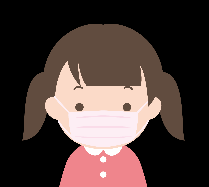

### パスとハイパーパラメータ

In [ ]:
if not MATCH_ONLY:
    PRETRAINED_PATH = '../input/coleridge-mlm-model/mlm-model'
    TOKENIZER_PATH = '../input/coleridge-mlm-model/model_tokenizer'

    MAX_LENGTH = 64
    OVERLAP = 20

    PREDICT_BATCH = 32 # a higher value requires higher GPU memory usage

    DATASET_SYMBOL = '$' # this symbol represents a dataset name
    NONDATA_SYMBOL = '#' # this symbol represents a non-dataset name

#データを MLM 形式に変換する

### Load model and tokenizer

🎉エンコーダーはAutoTokenizer.from_pretrained()で呼び出せます。bert-base-japaneseはWikipediaの日本語版で事前学習済みのサブワード辞書となります。今回は、日本語は使いませんので、'../input/coleridge-mlm-model/model_tokenizer'を使っています。

In [ ]:
if not MATCH_ONLY:
    tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, use_fast=True)
    model = AutoModelForMaskedLM.from_pretrained(PRETRAINED_PATH)

    mlm = pipeline(
        'fill-mask', 
        model=model,
        tokenizer=tokenizer,
        device=0 if torch.cuda.is_available() else -1
    )

### 補助機能

In [ ]:
def jaccard_similarity(s1, s2): #空白でsplit
    l1 = s1.split(" ")
    l2 = s2.split(" ")    
    intersection = len(list(set(l1).intersection(l2)))
    union = (len(l1) + len(l2)) - intersection
    return float(intersection) / union

def clean_paper_sentence(s): #数字、英字を空白に変換。+も空白に変換。
    """
    この関数は、基本的に小文字のない clean_text です。
    """
    s = re.sub('[^A-Za-z0-9]+', ' ', str(s)).strip()
    s = re.sub(' +', ' ', s)
    return s

def shorten_sentences(sentences):
    """
    MAX_LENGTH単語以上の文は分割されます
     重複して複数の文に。
    """
    short_sentences = []
    for sentence in sentences:
        words = sentence.split()
        if len(words) > MAX_LENGTH:
            for p in range(0, len(words), MAX_LENGTH - OVERLAP):
                short_sentences.append(' '.join(words[p:p+MAX_LENGTH]))
        else:
            short_sentences.append(sentence)
    return short_sentences

connection_tokens = {'s', 'of', 'and', 'in', 'on', 'for', 'data', 'dataset'}
def find_mask_candidates(sentence):
    """
    指定された $sentence から Masked Dataset Modeling のマスキング候補を抽出します。
     候補は少なくとも 2 単語の連続したシーケンスでなければなりません。
     これらの各単語は、最初の文字が大文字か、次のいずれかです。
     接続ワード ($connection_tokens)。 さらに、接続は
     トークンの最初と最後に出現することは許可されていません。
     シーケンス。
    """
    def candidate_qualified(words):
        while len(words) and words[0].lower() in connection_tokens:
            words = words[1:]
        while len(words) and words[-1].lower() in connection_tokens:
            words = words[:-1]
        
        return len(words) >= 2
    
    candidates = []
    
    phrase_start, phrase_end = -1, -1
    for id in range(1, len(sentence)):
        word = sentence[id]
        if word[0].isupper() or word in connection_tokens:
            if phrase_start == -1:
                phrase_start = phrase_end = id
            else:
                phrase_end = id
        else:
            if phrase_start != -1:
                if candidate_qualified(sentence[phrase_start:phrase_end+1]):
                    candidates.append((phrase_start, phrase_end))
                phrase_start = phrase_end = -1
    
    if phrase_start != -1:
        if candidate_qualified(sentence[phrase_start:phrase_end+1]):
            candidates.append((phrase_start, phrase_end))
    
    return candidates

### Transform

In [ ]:
if not MATCH_ONLY:
    mask = mlm.tokenizer.mask_token
    all_test_data = []
    
    for paper_id in tqdm(sample_submission['Id']):
        # load paper
        paper = papers[paper_id]

        # extract sentences
        sentences = set([clean_paper_sentence(sentence) for section in paper 
                         for sentence in section['text'].split('.')
                        ])
        sentences = shorten_sentences(sentences) # make sentences short
        sentences = [sentence for sentence in sentences if len(sentence) > 1] # only accept sentences with length > 1 chars
        sentences = [sentence for sentence in sentences if any(word in sentence.lower() for word in ['data', 'study'])]
        sentences = [sentence.split() for sentence in sentences] # sentence = list of words

        # mask
        test_data = []
        for sentence in sentences:
            for phrase_start, phrase_end in find_mask_candidates(sentence):
                dt_point = sentence[:phrase_start] + [mask] + sentence[phrase_end+1:]
                test_data.append((' '.join(dt_point), ' '.join(sentence[phrase_start:phrase_end+1]))) # (masked text, phrase)

        all_test_data.append(test_data)

🎉変数の中身を見てみる。

In [ ]:
sample_submission['Id']

In [ ]:
papers['2100032a-7c33-4bff-97ef-690822c43466'][0]

In [ ]:
sentence

In [ ]:
all_test_data[0]

### Predict

In [ ]:
if not MATCH_ONLY:
    pred_mlm_labels = []

    for test_data in tqdm(all_test_data):
        pred_bag = set()

        if len(test_data):
            texts, phrases = list(zip(*test_data))
            mlm_pred = []
            for p_id in range(0, len(texts), PREDICT_BATCH):
                batch_texts = texts[p_id:p_id+PREDICT_BATCH]
                batch_pred = mlm(list(batch_texts), targets=[f' {DATASET_SYMBOL}', f' {NONDATA_SYMBOL}'])

                if len(batch_texts) == 1:
                    batch_pred = [batch_pred]

                mlm_pred.extend(batch_pred)

            for (result1, result2), phrase in zip(mlm_pred, phrases):
                if (result1['score'] > result2['score']*2 and result1['token_str'] == DATASET_SYMBOL) or\
                   (result2['score'] > result1['score']*2 and result2['token_str'] == NONDATA_SYMBOL):
                    pred_bag.add(clean_text(phrase))

        # filter labels by jaccard score 
        filtered_labels = []

        for label in sorted(pred_bag, key=len, reverse=True):
            if len(filtered_labels) == 0 or all(jaccard_similarity(label, got_label) < 0.75 for got_label in filtered_labels):
                filtered_labels.append(label)

        pred_mlm_labels.append('|'.join(filtered_labels))
    
    pred_mlm_labels[:5]

# Baseline Model

In [ ]:
def read_append_return(filename, train_files_path=train_files_path, output='text'):
    """
    json ファイルを読み取り、そこからテキスト データを返し、データフレームに追加する関数
    """
    json_path = os.path.join(train_files_path, (filename+'.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
    
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data
    
    
def text_cleaning(text):
    '''
    すべてのテキストを小文字に変換し、特殊文字、絵文字、複数のスペースを削除します。テキスト - クリーンアップが必要な文
    '''
    text = ''.join([k for k in text if k not in string.punctuation])
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
    # text = re.sub("/'+/g", ' ', text)
    return text

🎉BASELINE_HELPING or ALL_BLENDED:の意味がよくわからない

In [ ]:
if BASELINE_HELPING or ALL_BLENDED:
    tqdm.pandas()

    train['text'] = train['Id'].progress_apply(read_append_return)

    if not COMPUTE_CV:
        sample_submission['text'] = sample_submission['Id'].progress_apply(partial(read_append_return, train_files_path=test_files_path))

    train.head()

In [ ]:
if BASELINE_HELPING or ALL_BLENDED:
    tqdm.pandas()
    
    train['text'] = train['text'].progress_apply(text_cleaning)

In [ ]:
if BASELINE_HELPING or ALL_BLENDED:
    temp_1 = [x.lower() for x in train['dataset_label'].unique()]
    temp_2 = [x.lower() for x in train['dataset_title'].unique()]
    temp_3 = [x.lower() for x in train['cleaned_label'].unique()]

    existing_labels = set(temp_1 + temp_2 + temp_3)

    print(f'len(temp_1) = {len(temp_1)}')
    print(f'len(temp_2) = {len(temp_2)}')
    print(f'len(temp_3) = {len(temp_3)}')
    print(f'len(existing_labels) = {len(existing_labels)}')

    id_list = []
    lables_list = []
    for index, row in tqdm(sample_submission.iterrows()):
        sample_text = row['text']
        row_id = row['Id']
        temp_df = train[train['text'] == text_cleaning(sample_text)]
        cleaned_labels = temp_df['cleaned_label'].to_list()

        for known_label in existing_labels:
            if known_label in sample_text.lower():
                cleaned_labels.append(clean_text(known_label))

        cleaned_labels = [clean_text(x) for x in cleaned_labels]
        cleaned_labels = set(cleaned_labels)
        lables_list.append('|'.join(cleaned_labels))
        id_list.append(row_id)

## submission file

🎉変数の中身を見てみる。

In [ ]:
pred_mlm_labels

In [ ]:
final_predictions = []

if ALL_BLENDED:
    for literal_match, mlm_pred, lables_match in zip(literal_preds, pred_mlm_labels, lables_list):
        temp = [literal_match, mlm_pred, lables_match]
        temp = [pred for pred in temp if pred]
        temp = ('|').join(temp)
        final_predictions.append(temp)
        
elif BASELINE_HELPING:
    for literal_match, mlm_pred, lables_match in zip(literal_preds, pred_mlm_labels, lables_list):
        if literal_match:
            final_predictions.append(literal_match)
        elif lables_match:
            final_predictions.append(lables_match)
        else:
            final_predictions.append(mlm_pred)

elif MATCH_ONLY:
    final_predictions = literal_preds

elif MLM_ONLY:
    final_predictions = pred_mlm_labels

elif THEO_MERGE:
    for i in range(len(literal_preds)):
        pred_naive = literal_preds[i].split('|')
        pred_model = pred_mlm_labels[i].split('|')
        pred_model_kept = []
        for pred_m in pred_model:
            kept = True
            for pred_n in pred_naive:
                if pred_m in pred_n or pred_n in pred_m:
                    kept = False
            if kept:
                pred_model_kept.append(pred_m)
        final_predictions.append("|".join(pred_naive + pred_model_kept))

else:
    for literal_match, mlm_pred in zip(literal_preds, pred_mlm_labels):
        if literal_match:
            final_predictions.append(literal_match)
        else:
            final_predictions.append(mlm_pred)

sample_submission['PredictionString'] = final_predictions

In [ ]:
sample_submission['PredictionString'] = final_predictions
sample_submission[['Id', 'PredictionString']].to_csv('submission.csv', index=False)

sample_submission.head()

# 評価指標

In [ ]:
# https://www.kaggle.com/c/coleridgeinitiative-show-us-the-data/discussion/230091
def compute_fbeta(y_true: List[List[str]],
                  y_pred: List[List[str]],
                  beta: float = 0.5) -> float:
    """Compute the Jaccard-based micro FBeta score.

    References
    ----------
    - https://www.kaggle.com/c/coleridgeinitiative-show-us-the-data/overview/evaluation
    """

    def _jaccard_similarity(str1: str, str2: str) -> float:
        a = set(str1.split()) 
        b = set(str2.split())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))

    tp = 0  # true positive
    fp = 0  # false positive
    fn = 0  # false negative
    for ground_truth_list, predicted_string_list in zip(y_true, y_pred):
        predicted_string_list_sorted = sorted(predicted_string_list)
        for ground_truth in sorted(ground_truth_list):            
            if len(predicted_string_list_sorted) == 0:
                fn += 1
            else:
                similarity_scores = [
                    _jaccard_similarity(ground_truth, predicted_string)
                    for predicted_string in predicted_string_list_sorted
                ]
                matched_idx = np.argmax(similarity_scores)
                if similarity_scores[matched_idx] >= 0.5:
                    predicted_string_list_sorted.pop(matched_idx)
                    tp += 1
                else:
                    fn += 1
        fp += len(predicted_string_list_sorted)

    tp *= (1 + beta ** 2)
    fn *= beta ** 2
    fbeta_score = tp / (tp + fp + fn)
    return fbeta_score

In [ ]:
if COMPUTE_CV:
    COMPUTE_CV_SCORE = compute_fbeta(sample_submission['cleaned_label'].apply(lambda x: [x]),\
                  sample_submission['PredictionString'].apply(lambda x: x.split('|')))
    print('COMPUTE_CV_SCORE =', COMPUTE_CV_SCORE)
else:
    print(f'COMPUTE_CV = {COMPUTE_CV}')
    
print(f'EDA_DEMO = {EDA_DEMO}')
print(f'ALL_BLENDED = {ALL_BLENDED}')
print(f'BASELINE_HELPING = {BASELINE_HELPING}')
print(f'MATCH_ONLY = {MATCH_ONLY}')
print(f'MLM_ONLY = {MLM_ONLY}')
print(f'KEN_MATCHING = {KEN_MATCHING}')
print(f'BS_CLEANING = {BS_CLEANING}')
print(f'THEO_MERGE = {THEO_MERGE}')
print(f'SEED = {SEED}')

|   | CV | LB |
| --- | --- | --- |
| s57 adnl_govt_labels |   | 0.573 |
| 42 w/ adnl_govt_labels |   | 0.557 |
| adnl_govt_labels_26897 | 0.136 |   |
| adnl_govt_labels |   | 0.556 |
| adnl_govt_labels KEN |   |   |
| 42 w/ adnl_govt_labels KEN |   | 0.557 |
| **RKM adnl_govt_labels w/ 42** | **0.514** | **0.574** |
| 42 only |   | 0.154 |
| RKM adnl_govt_labels BS_CLEANING w/ 42 |   | 0.568 |
| RKM adnl_govt_labels_26897 |   | 0.244 |
| RKM adnl_govt_labels w/ 42_48 |   | 0.574 |
| **RKM adnl_govt_labels w/ 42_36** |   | **0.574** |
| RKM adnl_govt_labels w/ 42_60 |   | 0.574 |
| RKM adnl_govt_labels w/ 42_24 |   | 0.573 |
| RKM adnl_govt_labels w/ 42_60 |   | 0.573 |
| RKM adnl_govt_labels w/ 42_60 TM |   | 0.553 |